# A Computational Analysis of Walt Whitman's Stylistic Changes in *Leaves of Grass*

In [67]:
import requests 
from bs4 import BeautifulSoup

import pandas as pd
from macroetym.main import Text

# Make sure the following corpora are downloaded
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('vader_lexicon')
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import vader
from nltk.sentiment import SentimentIntensityAnalyzer, SentimentAnalyzer
from nltk.corpus import cmudict

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import patches as mpatch

import math
from statistics import mean, stdev
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

In [2]:
# Import stopwords
stopWords = stopwords.words('english')

In [3]:
stopWords[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [4]:
# Load whitman texts
whitman1855TEI = open('./texts/whitman1855.xml', encoding='utf-8').read()
whitman1856TEI = open('./texts/whitman1856.xml', encoding='utf-8').read()
whitman1860TEI = open('./texts/whitman1860.xml', encoding='utf-8').read()
whitman1867TEI = open('./texts/whitman1867.xml', encoding='utf-8').read()
whitman1871TEI = open('./texts/whitman1871-2.xml', encoding='utf-8').read()
whitman1881TEI = open('./texts/whitman1881-2.xml', encoding='utf-8').read()
whitman1891TEI = open('./texts/whitman1891-2.xml', encoding='utf-8').read()

In [5]:
allWhitmanTEI = [whitman1855TEI, whitman1856TEI, whitman1860TEI, whitman1867TEI, whitman1871TEI, whitman1881TEI, whitman1891TEI]

In [6]:
def getSoup(fileTEI):
    soup = BeautifulSoup(fileTEI, features='lxml')
    return soup

def getLineGroups(soup):
    '''This function returns a list of all linegroups 
    in a text processed by BeautifulSoup.'''
    lineGroups = soup.find_all('lg')
    stanzaGroups = []
    for lineGroup in lineGroups:
        if len(list(lineGroup.attrs.keys())) > 0 :
            if lineGroup.attrs['type'] == "linegroup":
                stanzaGroups.append(lineGroup)
            elif lineGroup.attrs['type'] == "section":
                flag = True
                des = list(lineGroup.descendants)
                for item in des:
                    try:
                        if len(item.attrs.keys()) > 0:
                            if item.attrs['type'] == 'linegroup' or item.attrs['type'] == 'poem':
                                flag = False
                    except:
                        continue
                if flag == True:
                    stanzaGroups.append(lineGroup)
            elif lineGroup.attrs['type'] == "poem":
                des = list(lineGroup.descendants)
                flag = True
                for item in des:
                    try:
                        if len(item.attrs.keys()) > 0:
                            if item.attrs['type'] == 'linegroup' or item.attrs['type'] == 'section':
                                flag = False
                    except:
                        continue
                if flag == True:
                    stanzaGroups.append(lineGroup)
    return stanzaGroups
    
def getText(lineGroups):
    text = [lineGroup.text for lineGroup in lineGroups]
    return ''.join(text)
    
def getTitle(soup):
    title = soup.title.text
    return title

In [96]:
whitmanSoups = [getSoup(fileTEI) for fileTEI in allWhitmanTEI]

/Applications/anaconda3/lib/python3.8/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


In [97]:
whitmanTitles = [getTitle(soup).replace('\n', '') for soup in whitmanSoups]
whitmanTitles

['Leaves of Grass (1855)',
 'Leaves of Grass (1856)',
 'Leaves of Grass (1860–61)',
 'Leaves of Grass (1867)',
 'Leaves of Grass (1871–72)',
 'Leaves of Grass (1881-82)',
 'Leaves of Grass (1891-92)']

In [98]:
# Number of stanzas in different editions of Leaves
whitmanStanzasNumber = {title: len(getLineGroups(soup)) for title, soup in zip(whitmanTitles, whitmanSoups)}
whitmanStanzas = {title: getLineGroups(soup) for title, soup in zip(whitmanTitles, whitmanSoups)}
whitmanStanzasNumber

{'Leaves of Grass (1855)': 643,
 'Leaves of Grass (1856)': 969,
 'Leaves of Grass (1860–61)': 1418,
 'Leaves of Grass (1867)': 1627,
 'Leaves of Grass (1871–72)': 1381,
 'Leaves of Grass (1881-82)': 1948,
 'Leaves of Grass (1891-92)': 2072}

In [99]:
# Samples of different editions of Leaves
whitmanTexts = [getText(getLineGroups(soup)) for soup in whitmanSoups]
for text in whitmanTexts:
    print(text[:50],end='\n')
    print(text[-50:], end='\n')


I CELEBRATE myself,
And what I assume you shall a
 they merge in the light, death is great as life.


I CELEBRATE myself, 
And what I assume you shall 
nd two waiters.
The Tragic Muse in a gold frame. 


FREE, fresh, savage,
Fluent, luxuriant, self-cont
rials,
I am as one disembodied, triumphant, dead.



INSCRIPTION.

SMALL
is the theme of the followin
rials,
I am as one disembodied, triumphant, dead.


ONE'S-SELF I sing—a simple, separate Person;
Yet 
rials;
I am as one disembodied, triumphant, dead.


ONE'S-SELF I sing, a simple separate person,
Yet 
rials,
I am as one disembodied, triumphant, dead.


COME, said my Soul,
Such verses for my Body let u
ripples, half-caught voices, echo from the shore.



# Stanzas

In [100]:
def getLines(lineGroup):
    lines = lineGroup.find_all('l')
    return lines

In [101]:
# Extract lines from each linegroup in Whitman
whitmanStanzaSizes = {}
for title, soup in zip(whitmanTitles, whitmanSoups):
    lineGroups = getLineGroups(soup)
    lineNumberList = []
    for lineGroup in lineGroups:
        lineNumber = len(getLines(lineGroup))
        lineNumberList.append(lineNumber)
    whitmanStanzaSizes[title] = lineNumberList

In [102]:
len(whitmanStanzaSizes['Leaves of Grass (1881-82)'])

1948

In [103]:
# Compute mean and std of stanza sizes
whitmanStanzaStats = {title: [mean(stanzaSizes), stdev(stanzaSizes)] for title, stanzaSizes in whitmanStanzaSizes.items()}

In [104]:
pd.DataFrame(whitmanStanzaStats, index = ['mean', 'std'])

,Leaves of Grass (1855),Leaves of Grass (1856),Leaves of Grass (1860–61),Leaves of Grass (1867),Leaves of Grass (1871–72),Leaves of Grass (1881-82),Leaves of Grass (1891-92)
mean,3.600311,4.393189,4.750353,4.872772,5.005793,5.099589,5.198359
std,5.372753,6.043164,6.542064,5.912995,6.328104,5.397439,5.334738


# Parentheses

In [105]:
whitmanWords = {title: nltk.word_tokenize(text.lower()) for title, text in zip(whitmanTitles, whitmanTexts)}

In [106]:
# Compute the ratio of parentheses in Leaves
whitmanParenthesesRatio = {title: words.count('(') / len(words) for title, words in whitmanWords.items()}

In [107]:
whitmanParenthesesRatio

{'Leaves of Grass (1855)': 5.375621556242441e-05,
 'Leaves of Grass (1856)': 0.0003099141537794031,
 'Leaves of Grass (1860–61)': 0.0011543368638490046,
 'Leaves of Grass (1867)': 0.0022875702860335975,
 'Leaves of Grass (1871–72)': 0.0026691992402279314,
 'Leaves of Grass (1881-82)': 0.0029470636462341844,
 'Leaves of Grass (1891-92)': 0.003301275492804038}

# Self-Identity

In [108]:
def findSelves1(words):
    '''This function counts the frequency of "i" in words.'''
    counts = words.count('i')
    return counts

In [109]:
def findSelves2(words):
    '''This function counts the frequency of "myself", "me", "self", "my", "mine" in words.'''
    counts = words.count('myself') + words.count('me') + words.count('self') + words.count('my') + words.count('mine')
    return counts

In [110]:
whitmanSelvesRatio1 = {title: findSelves1(words)/len(words) for title, words in whitmanWords.items()}
whitmanSelvesRatio2 = {title: findSelves2(words)/len(words) for title, words in whitmanWords.items()}

In [111]:
whitmanSelvesRatio1

{'Leaves of Grass (1855)': 0.019836043542534605,
 'Leaves of Grass (1856)': 0.020841726841664857,
 'Leaves of Grass (1860–61)': 0.022256424795965898,
 'Leaves of Grass (1867)': 0.021635874690042956,
 'Leaves of Grass (1871–72)': 0.02093371988403479,
 'Leaves of Grass (1881-82)': 0.020703306767905813,
 'Leaves of Grass (1891-92)': 0.019671236614146374}

In [112]:
whitmanSelvesRatio2

{'Leaves of Grass (1855)': 0.01609998656094611,
 'Leaves of Grass (1856)': 0.01400811975082902,
 'Leaves of Grass (1860–61)': 0.016504992000648047,
 'Leaves of Grass (1867)': 0.016615443718786017,
 'Leaves of Grass (1871–72)': 0.01601519544136759,
 'Leaves of Grass (1881-82)': 0.015629039286795824,
 'Leaves of Grass (1891-92)': 0.015149034854375553}

# Stylometry and Macro-Etymological Analysis

## Stylometry

In [113]:
# tf-idf most frequent 400 content words
tfidfVectorizer = TfidfVectorizer(max_features=400, stop_words=stopWords)
textMatrix = tfidfVectorizer.fit_transform(whitmanTexts)
denseTextMatrix = textMatrix.todense()
denseTextMatrix.shape

(7, 400)

In [114]:
# Apply 2d PCA to text matrix 
pca = PCA(n_components=2)
textPoints = pca.fit_transform(np.asarray(denseTextMatrix))
textPoints.shape

(7, 2)

In [115]:
def getTextHTML(url):
    response = requests.get(url)
    if response.ok:
        text = response.text
        return text
    else:
        print('ERROR: Invalid url!')

In [116]:
# Retrieve reviews of Leaves
reviews1855 = getTextHTML('https://whitmanarchive.org/criticism/reviews/lg1855/index.html')
reviews1856 = getTextHTML('https://whitmanarchive.org/criticism/reviews/lg1856/index.html')
reviews1860 = getTextHTML('https://whitmanarchive.org/criticism/reviews/lg1860/index.html')
reviews1867 = getTextHTML('https://whitmanarchive.org/criticism/reviews/lg1867/index.html')
reviews1871 = getTextHTML('https://whitmanarchive.org/criticism/reviews/lg1871/index.html')
reviews1881 = getTextHTML('https://whitmanarchive.org/criticism/reviews/lg1881/index.html')
reviews1891 = getTextHTML('https://whitmanarchive.org/criticism/reviews/lg1891/index.html')

In [117]:
allReviews = [reviews1855, reviews1856, reviews1860, reviews1867, reviews1871, reviews1881, reviews1891]

In [118]:
reviewsSoups = [getSoup(reviews) for reviews in allReviews]

In [119]:
# Count the number of reviews fro each edition of Whitman
reviewsNums = [len(soup.find_all('li')) for soup in reviewsSoups]
reviewsNums

[26, 7, 35, 5, 5, 41, 1]

In [120]:
def euclideanD(df):
    '''THis function calculates the Euclidean distance among rows of a df.'''
    allDistances = []
    rowNums = df.shape[0]
    for i in range(rowNums):
        if i > 0:
            xDist = (df.loc[i][0] - df.loc[i-1][0])**2
            yDist = (df.loc[i][1] - df.loc[i-1][1])**2
            sqrtDist = math.sqrt(xDist + yDist)
            allDistances.append(sqrtDist)
        else:
            sqrtDist = math.sqrt(df.loc[0][0]**2 + df.loc[0][0]**2)
            allDistances.append(sqrtDist)
    return allDistances

In [121]:
textDFRaw = pd.DataFrame(textPoints)
whitmanDists = euclideanD(textDFRaw)
whitmanDists

[0.28509920592474375,
 0.2455082032191713,
 0.08982884807789054,
 0.09914627410669231,
 0.01754037275415943,
 0.3068928796960644,
 0.0365578863454595]

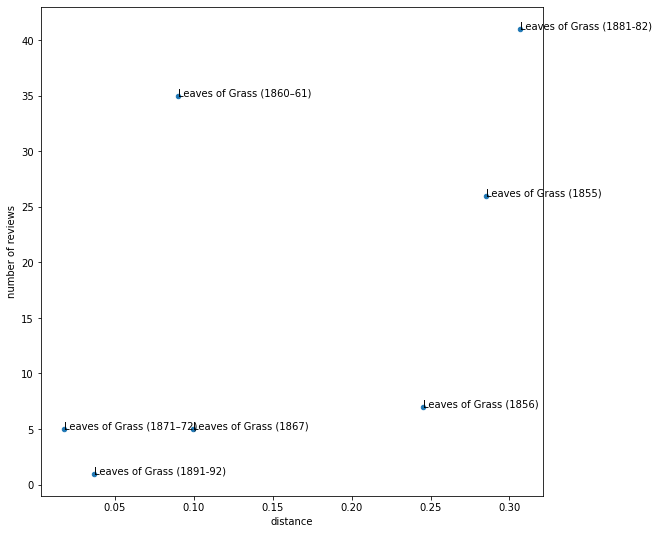

In [122]:
# Plot how number of reviews change with respect to distance
correlationDF = pd.DataFrame(zip(whitmanDists, reviewsNums), index=whitmanTitles, columns=['distance', 'number of reviews'])
ax = correlationDF.plot(kind='scatter', x='distance', y='number of reviews', figsize=(9,9))
for title, point in correlationDF.iterrows():
    ax.annotate(title, point)
plt.savefig('./figures/correlation.png', dpi=300, bbox_inches='tight')

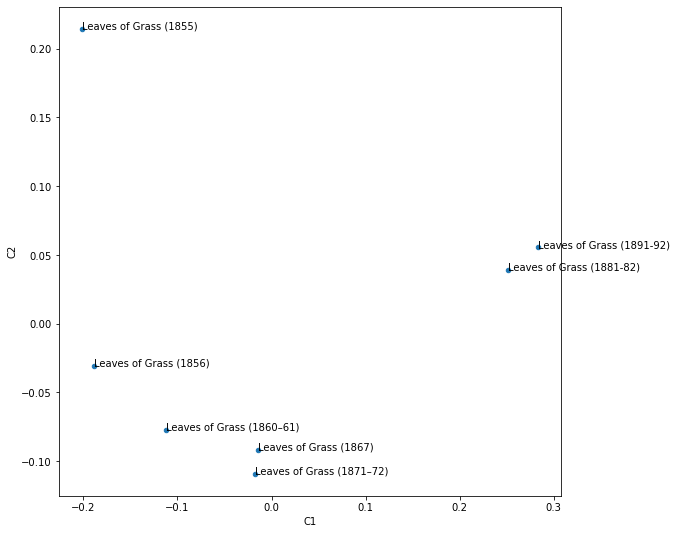

In [123]:
# Plot PC1 and PC2
textDF = pd.DataFrame(textPoints, index=whitmanTitles, columns=['C1', 'C2'])
ax = textDF.plot(kind='scatter', x='C1', y='C2',figsize=(9,9))
for title, point in textDF.iterrows():
    ax.annotate(title, point)
plt.savefig('./figures/stylometry.png', dpi=300, bbox_inches='tight')

In [124]:
# Compute correlation coefficient between distance and number of reviews
covariance = 0
for i in range(len(whitmanDists)):
    covariance += (whitmanDists[i] - mean(whitmanDists))*(reviewsNums[i] - mean(reviewsNums))
covariance = covariance / 6
correlation = covariance/(stdev(whitmanDists)*stdev(reviewsNums))
correlation

0.5799479777560573

In [125]:
# Remove 1856 and 1861 edition for correlation analysis
whitmanDists2 = [whitmanDists[0]] + whitmanDists[3:]
reviewsNums2 = [reviewsNums[0]] + reviewsNums[3:]
correlation2 = np.cov(whitmanDists2, reviewsNums2)[0][1]/(stdev(whitmanDists2)*stdev(reviewsNums2))
correlation2

0.9456412907877846

## Macro-Etymological Analysis

In [126]:
# Macro-etymological analysis
whitmanEtyms = [Text(text) for text in whitmanTexts]

In [127]:
etymsData = {title: etym.prettyStats for title, etym in zip(whitmanTitles, whitmanEtyms)}

In [128]:
etymsDF = pd.DataFrame(etymsData).fillna(0)

In [129]:
etymsDF.iloc[:7]

,Leaves of Grass (1855),Leaves of Grass (1856),Leaves of Grass (1860–61),Leaves of Grass (1867),Leaves of Grass (1871–72),Leaves of Grass (1881-82),Leaves of Grass (1891-92)
Old English (ca. 450-1100),40.34,36.44,34.37,34.57,34.72,33.46,33.14
Middle French (ca. 1400-1600),3.73,4.02,4.27,4.52,4.59,4.50,4.42
Latin,14.66,17.10,18.88,18.39,18.15,19.26,19.67
French,7.19,8.11,8.44,8.71,8.72,8.66,8.84
Old French (842-ca. 1400),20.53,20.87,20.63,20.74,20.86,20.85,20.74
Old Norse,3.13,2.73,2.55,2.46,2.50,2.40,2.43
Anglo-Norman,6.80,6.51,6.80,6.61,6.52,6.42,6.31


# Sentiment Analysis

In [130]:
sentimentAnalyzer = SentimentIntensityAnalyzer()

In [131]:
def getSentiment(text):
    return sentimentAnalyzer.polarity_scores(text)['compound']

In [132]:
# Test on 'O Captain! My Captain!'
testSents = ["O CAPTAIN! my captain! our fearful trip is done;", "The ship has weather'd every rack, the prize we sought is won;",
            "The port is near, the bells I hear, the people all exulting,", "While follow eyes the steady keel, the vessel grim and daring:",
            "But O heart! heart! heart!", "Leave you not the little spot,", "Where on the deck my captain lies.", "Fallen cold and dead."]

In [133]:
# Polarity score of each test sentence
[getSentiment(sent) for sent in testSents]

[-0.5837, 0.7906, 0.0, -0.296, 0.0, -0.0516, -0.4215, -0.7783]

In [134]:
# Average polarity score of test sentences
mean([getSentiment(sent) for sent in testSents])

-0.1675625

In [135]:
# A dictionary of all sentences in different editions of Leaves
whitmanLines = {}
for title, stanzas in whitmanStanzas.items():
    allLines = []
    for stanza in stanzas:
        lines = stanza.find_all('l')
        allLines += lines
    whitmanLines[title] = allLines

In [136]:
whitmanSentiments = {}
for title, lines in whitmanLines.items():
    whitmanSentiments[title] = mean([getSentiment(line.text) for line in lines])
whitmanSentiments

{'Leaves of Grass (1855)': 0.08893965442764579,
 'Leaves of Grass (1856)': 0.09273218228799625,
 'Leaves of Grass (1860–61)': 0.09125483966745844,
 'Leaves of Grass (1867)': 0.07971285317860746,
 'Leaves of Grass (1871–72)': 0.07971787935773181,
 'Leaves of Grass (1881-82)': 0.08384613448761828,
 'Leaves of Grass (1891-92)': 0.0816083279175564}

In [137]:
# Time series of sentiments in Whitman
whitmanAllSentiments = {}
for title, lines in whitmanLines.items():
    whitmanAllSentiments[title] = pd.Series([getSentiment(line.text) for line in lines])

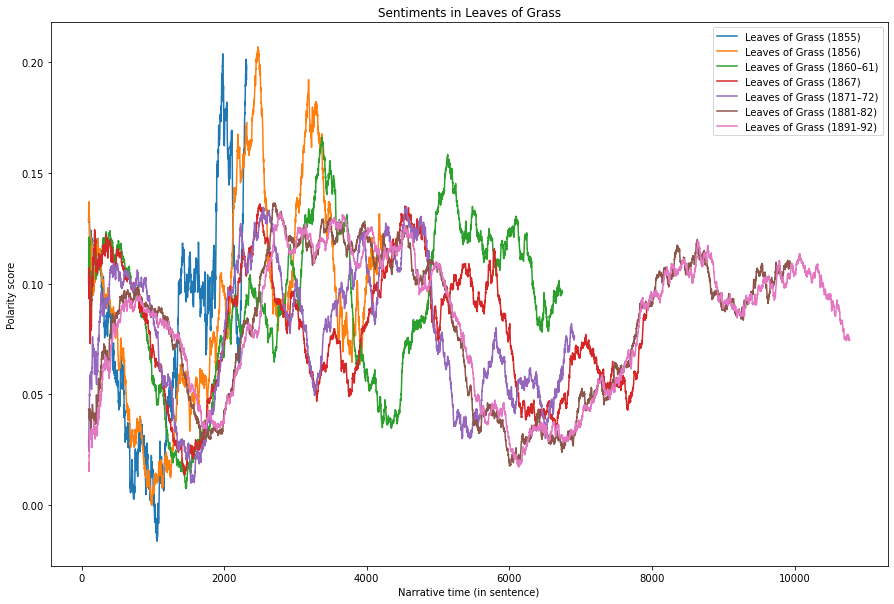

In [138]:
# Plot all time series of sentiments in Whitman on one graph
plt.figure(figsize=(15, 10))
plt.plot(whitmanAllSentiments['Leaves of Grass (1855)'].rolling(int(0.1*len(whitmanLines['Leaves of Grass (1855)'])), min_periods=100).mean(), 
        label='Leaves of Grass (1855)')
plt.plot(whitmanAllSentiments['Leaves of Grass (1856)'].rolling(int(0.1*len(whitmanLines['Leaves of Grass (1856)'])), min_periods=100).mean(),
        label='Leaves of Grass (1856)')
plt.plot(whitmanAllSentiments['Leaves of Grass (1860–61)'].rolling(int(0.1*len(whitmanLines['Leaves of Grass (1860–61)'])), min_periods=100).mean(),
        label='Leaves of Grass (1860–61)')
plt.plot(whitmanAllSentiments['Leaves of Grass (1867)'].rolling(int(0.1*len(whitmanLines['Leaves of Grass (1867)'])), min_periods=100).mean(), 
        label='Leaves of Grass (1867)')
plt.plot(whitmanAllSentiments['Leaves of Grass (1871–72)'].rolling(int(0.1*len(whitmanLines['Leaves of Grass (1871–72)'])), min_periods=100).mean(),
        label='Leaves of Grass (1871–72)')
plt.plot(whitmanAllSentiments['Leaves of Grass (1881-82)'].rolling(int(0.1*len(whitmanLines['Leaves of Grass (1881-82)'])), min_periods=100).mean(),
        label='Leaves of Grass (1881-82)')
plt.plot(whitmanAllSentiments['Leaves of Grass (1891-92)'].rolling(int(0.1*len(whitmanLines['Leaves of Grass (1891-92)'])), min_periods=100).mean(),
        label='Leaves of Grass (1891-92)')
plt.title('Sentiments in Leaves of Grass')
plt.xlabel('Narrative time (in sentence)')
plt.ylabel('Polarity score')
plt.legend(loc='best')
plt.savefig('./figures/sentiment.png', dpi=300, bbox_inches='tight')
plt.show()

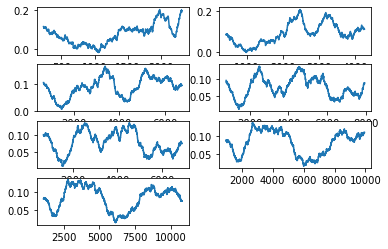

In [139]:
plt.figure()
plt.subplot(421)
plt.plot(whitmanAllSentiments['Leaves of Grass (1855)'].rolling(int(0.1*len(whitmanLines['Leaves of Grass (1855)']))).mean())

plt.subplot(422)
plt.plot(whitmanAllSentiments['Leaves of Grass (1856)'].rolling(int(0.1*len(whitmanLines['Leaves of Grass (1856)']))).mean())

plt.subplot(423)
plt.plot(whitmanAllSentiments['Leaves of Grass (1860–61)'].rolling(int(0.1*len(whitmanLines['Leaves of Grass (1860–61)']))).mean())

plt.subplot(424)
plt.plot(whitmanAllSentiments['Leaves of Grass (1867)'].rolling(int(0.1*len(whitmanLines['Leaves of Grass (1867)']))).mean())

plt.subplot(425)
plt.plot(whitmanAllSentiments['Leaves of Grass (1871–72)'].rolling(int(0.1*len(whitmanLines['Leaves of Grass (1871–72)']))).mean())

plt.subplot(426)
plt.plot(whitmanAllSentiments['Leaves of Grass (1881-82)'].rolling(int(0.1*len(whitmanLines['Leaves of Grass (1881-82)']))).mean())

plt.subplot(427)
plt.plot(whitmanAllSentiments['Leaves of Grass (1891-92)'].rolling(int(0.1*len(whitmanLines['Leaves of Grass (1891-92)']))).mean())

plt.show()

# Lexical Complexity Analyzer by Haiyang

In [150]:
# Choose wordnet lemmatizer for lemmatization
lemmatizer = nltk.stem.WordNetLemmatizer()

In [148]:
# POS Tagger: nltk.pos_tag
def lcaPrep(text):
    '''This function prepares Whitman texts for lexical complexity analysis.'''
    tokens = nltk.word_tokenize(text)
    wordTags = nltk.pos_tag(tokens)
    lemmaTags = []
    for word, tag in wordTags:
        lemma = lemmatizer.lemmatize(word)
        lemmaTags.append((lemma, tag))
    return lemmaTags

In [143]:
whitman1855Tags = lcaPrep(whitmanTexts[0])
whitman1856Tags = lcaPrep(whitmanTexts[1])
whitman1860Tags = lcaPrep(whitmanTexts[2])
whitman1867Tags = lcaPrep(whitmanTexts[3])
whitman1871Tags = lcaPrep(whitmanTexts[4])
whitman1881Tags = lcaPrep(whitmanTexts[5])
whitman1891Tags = lcaPrep(whitmanTexts[6])

In [145]:
def writeWhitman(file, lemmaTags):
    temp = open(file, 'w', encoding='utf-8')
    for lemma, tag in lemmaTags:
        temp.write( lemma + '_'+ tag +' ')
    temp.close()

In [149]:
# writeWhitman('./texts/1855.txt', whitman1855Tags)
# writeWhitman('./texts/1856.txt', whitman1856Tags)
# writeWhitman('./texts/1860-61.txt', whitman1860Tags)
# writeWhitman('./texts/1867.txt', whitman1867Tags)
# writeWhitman('./texts/1871-72.txt', whitman1871Tags)
# writeWhitman('./texts/1881-82.txt', whitman1881Tags)
# writeWhitman('./texts/1891-92.txt', whitman1891Tags)